<a href="https://colab.research.google.com/github/project-ida/nuclear-reactions/blob/master/fusion-rates-gamow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/nuclear-reactions/blob/master/fusion-rates-gamow.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Fusion rates 01

In this notebook, we'll calculate nuclear fusion rates using the [Gamow model](https://web.archive.org/web/20200504014928/http://web.ihep.su/dbserv/compas/src/gamow28/eng.pdf). We'll first focus our attention the spontaneous fusion of two deuterons in a $\rm D_2$ molecule and then explore what fusion rates we might expect when $\rm D_2$ is absorbed into metals like palladium.

This notebook contains results and methods used for fusion rate plots from [Known mechanisms that increase nuclear fusion rates in the solid state](https://doi.org/10.1088/1367-2630/ad091c).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pandas as pd
from scipy.integrate import simps, trapz
pd.set_option('display.max_rows', 300)  # or None to display an unlimited number of rows

/Users/matt/anaconda3/envs/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Constants
e = 1.602176634e-19 # charge on the electron
eps0 = 8.85418782e-12 # permitivity of free space
hbar = 1.054571817e-34
amu = 1.66053906892e-27 # 1 amu in kg
a0 = 0.529177210903e-10 # bohr radius in m
Ry_to_eV = 13.605693122990 # 1 Rydberg in eV
J_to_eV = 1/1.602176634e-19 # 1 Joule in eV
eV_to_J = 1.602176634e-19 # 1 eV in Joules

In [3]:
# Deuterium information
deuteron_mass = 2.013553212745 * amu
muDD = ((deuteron_mass*deuteron_mass) / (deuteron_mass+deuteron_mass)) # reduced mass of D2 in kg

## Nuclear fusion

Fusion can be described as a two step process:
1. A quantum tunneling event through a potential barrier, with the barrier defined by the interatomic potential between two nuclei.
2. A relaxation or decay of the highly excited nuclei into some ground state or decay products (with the concomitant release of energy)

Step 1 is concerned with solving the Schrödinger equation to calculate the probability, $P$, that the the nuclei have passed the Coulomb barrier and are within each other's nuclear volume. Step 2 is concerned with nuclear physics and proceeds at a rate $\gamma$ that's typically extremely fast (~$10^{20} s^{-1}$).

The fusion rate per pair of nuclei can then be simply written as:

$$\Gamma = P\gamma$$

This two step approach is the most accurate way to calculate the fusion rate and we will explore it in the next notebook. In this notebook, we'd like to work with a simpler description, which is however commonly used. We're going to adapt the approximation of fusion as a collision process to the spontaneous fusion of $\rm D_2$ in a molecule.

### Fusion as a collision

In the collision picture, the fusion event occurs instantaneously when two nuclei collide with enough energy, $E$, to be within each others nuclear cross section which is given by:

$$\sigma = \frac{S(E)}{E}e^{-2G(E)}$$

$S(E)$ is the astrophysical S-factor which incorporates the nuclear physics part of the reaction.

$1/E$ takes into account the effective nuclear area as given by the square of the de Broglie wavelength $\lambda_D$:

$$\lambda_D = \frac{h}{p} \sim \frac{1}{\sqrt{E}}$$

$e^{-2G(E)}$ represents the difficulty in tunneling through the Coulomb barrier where $G$ is known as the Gamow factor:

$$G = \int_{r_1}^{r_2} \sqrt{\frac{2\mu}{\hbar^2}\left[V_{\rm}(r) - E\right]} \, dr$$

Here $V$ is the interatomic potential and $r_1$ and $r_2$ are the classical turning points for the potential barrier.

The fusion rate for the case of a single nucleus colliding at speed $v$ into a target with density $n$ is the particle flux multiplied by the cross section:

$$\Gamma = n\sigma v$$

### Spontaneous fusion of $\rm D_2$

Although there are no collisions in the spontaneous fusion of a $\rm D_2$ molecule, we can adapt the fusion rate expression from above through a helpful interpretation of $n\sigma v$:
- Without the Gamow factor, $\sigma v$ represents the reactable nuclear volume that's swept out by a colliding nucleus per unit time.
- $n \sigma v$ then counts how many nuclei are in this "reacting volume" to give us number of reactions per second.
- The Gamow factor effectively reduces the density of particles in the reacting volume due to the repulsion between the nuclei.

For the $D_2$ molecule:
- The reacting volume is just the volume of the nucleus $v_{nuc}$
- The rate at which particles in this volume react is given by $\gamma$
- The density of nuclei is calculated by the inverse the volume occupied by a single molecule $1/v_{mol}$.
- The effective density of nuclei in the reacting volume is $e^{-2G}/v_{mol}$ due to the repulsion of the nuclei.

This results in a fusion rate of:

$$\Gamma = \frac{v_{nuc}}{v_{mol}}e^{-2G} \gamma$$

where one can interpret $\frac{v_{nuc}}{v_{mol}}e^{-2G}$ as the probability for the particles to have traversed the Coulomb barrier. One might also have arrived at this probability from an intuitive consideration of a particle trapped in a box of volume $v_{mol}$ moving around randomly and seeking to land in a target volume $v_{mol}$ but hindered by a factor $e^{-2G}$.

Now we've got an expression for the fusion rate, we just have to calculate all the relevant pieces. Let's start with constructing the interatomic potential that's needed for the Gamow factor.

## Potentials

In the calculation of the Gamow factor, the interatomic potential needs to be augmented with the centripetal potential to create an effective potential:

$$V_{\rm eff}(r) = V(r) + \frac{L(L+1)\hbar^2}{2\mu r^2}$$


For a $\rm D_2$ molecule, the interatomic potential $V(r)$ consists of two parts - the nuclear and molecular potentials:

$$V(r) = V_{\rm nuc}^{S,L}(r) + V_{\rm mol}(r)$$



### Nuclear potential

We use the Woods-Saxon nuclear potential (in MeV):

$$V_{\rm nuc}^{S,L}(r) ~=~ {V_0 \over 1 + e^{(r - r_S) / a_S}}$$


In [4]:
# The nuclear Woods-Saxon nuclear potential
def V_nuc(r, V0, r_S, a_S):
    r_safe = np.minimum(r, 100) # Prevents overflow errors in the exponential when r is in the pm range
    return V0 / (1 + np.exp((r_safe - r_S) / a_S))

The parameters depend on the total spin ($S$) and orbital ($L$) angular momenta of the nuclei as seen below and can be found in [Tomusiak et.al](http://dx.doi.org/10.1103/physrevc.52.1963).

| State | $V_0$ (MeV) | $r_s$ (fm) | $a_s$ (fm) |
|-------|-------------|------------|------------|
| $^1S$ | -74.0       | 1.70       | 0.90       |
| $^5S$ | -15.5       | 3.59       | 0.81       |
| $^3P$ | -13.5       | 5.04       | 0.79       |
| $^5D$ | -15.5       | 3.59       | 0.81       |

In [5]:
# Parameters for nuclear potential depend on the state
states = [
    {"state": r"$^1S$: L=0, S=0", "L":0, "S":0, "V0": -74.0, "r_S": 1.70, "a_S": 0.90},
    {"state": r"$^5S$: L=0, S=2", "L":0, "S":2, "V0": -15.5, "r_S": 3.59, "a_S": 0.81},
    {"state": r"$^3P$: L=1, S=1", "L":1, "S":1, "V0": -13.5, "r_S": 5.04, "a_S": 0.79},
    {"state": r"$^5D$: L=2, S=2", "L":2, "S":2, "V0": -15.5, "r_S": 3.59, "a_S": 0.81},
]

We can then see that the attractive nuclear potentials become negligible beyond about 10 fm.

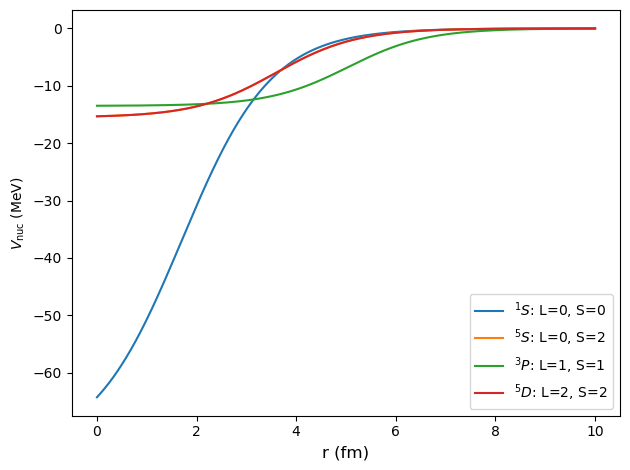

In [6]:
# Generate r values (distance in fm)
r_fm = np.linspace(0, 10, 500)

# Plot the potential for each state
plt.figure()
for state in states:
    V0, r_S, a_S = state["V0"], state["r_S"], state["a_S"]
    plt.plot(r_fm, V_nuc(r_fm, V0, r_S, a_S), label=state["state"])

# Customise the plot
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("$V_{\\rm nuc}$ (MeV)")
plt.legend()
plt.tight_layout()
# plt.savefig("nuc-potential-D2.png", dpi=600)
plt.show()

### Molecular potential

A $\rm D_2$ molecule exists because of a balance between the electrostatic repulsion between the nuclei and an attraction  between nuclei and the electron cloud. This balance results in a 74 pm equilibrium distance between the deuterons in a gas.

There are several options for representing the molecular potential. For example, the [Morse Potential](https://en.wikipedia.org/wiki/Morse_potential) is popular. For a more accurate potential, however, we will draw upon the work of [Kolos & Wolniewicz 1986](http://dx.doi.org/10.1063/1.1669836). We parameterised the numerical Kolos potential as:

$$V_{mol}(r) = \frac{2}{r}(1 - b_1r - b_2r^2) e^{-\alpha r^s}$$

with $r$ in units of the Bohr radius ($a_0$), $V_{mol}$ is in Rydbergs and with
- $\alpha = 0.6255121237003474$
- $b_1 = 1.4752572117720800$
- $b_2 = -0.2369829512108492$
- $s = 1.0659864120418940$

We'll make a function that aligns with the nuclear potential in the sense that it takes $r$ in fm and returns the potential in MeV.

In [7]:
alpha = 0.6255121237003474
b1 = 1.4752572117720800
b2 = -0.2369829512108492
s = 1.0659864120418940

# Kolos potential in MeV with r in fm
def V_mol(r_fm):
    r = r_fm*1e-15/a0 # fm to a0
    return (2 / r) * (1 - b1 * r - b2 * r**2) * np.exp(-alpha * r**s) * Ry_to_eV / 1e6

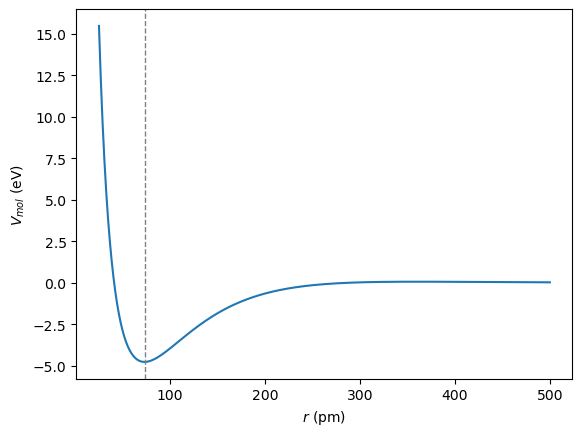

In [8]:
# Range for r in pm for plotting and fm for the potential functions
r_pm = np.linspace(25, 500, 500)
r_fm = r_pm*1000

# Calculate V_mol in MeV
V_mol_values = V_mol(r_fm)

# Plot
plt.figure()
plt.plot(r_pm, V_mol_values*1e6, label=r"$V_{mol}(r)$")
plt.xlabel(r"$r$ (pm)")
plt.ylabel(r"$V_{mol}$ (eV)")
plt.axvline(x=74, color="grey", linestyle='--', linewidth=1)
# plt.savefig("mol-potential-D2.png", dpi=600)
plt.show()

We can see how much energy the deuterons have in their equilibrium position of 74 pm:

In [9]:
V_mol(74000)*1e6

-4.770659045064353

To put this approximately $-5 \, \rm eV$ into perspective, we need to compare it with the energy that two deuterons would have in the absence of any binding electrons - i.e. the "bare" Coulomb potential. 

### Coulomb potential

Without the electrons the electrostatic potential between the deuterons is given by:

$$V_{\rm coulomb} = \frac{e^2}{4\pi\epsilon_0r}$$

In [10]:
# Coulomb potential in MeV with r in fm
def V_coulomb(r_fm):
    return e**2/(4 * np.pi * eps0 * r_fm*1e-15) * J_to_eV / 1e6

Let's plot $V_{\rm coulomb}$ and $V_{\rm mol}$ on the same scale for easy comparison.

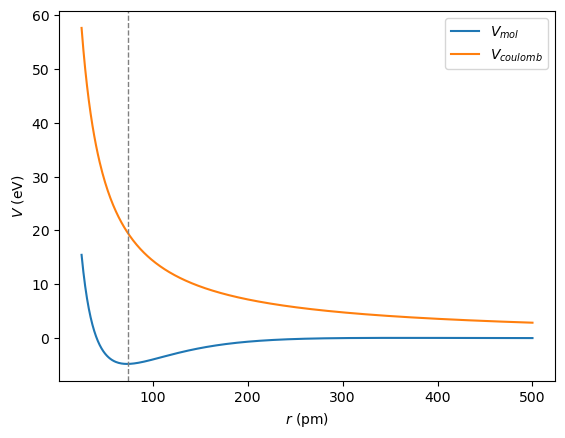

In [11]:
# Range for r in pm for plotting and fm for the potential functions
r_pm = np.linspace(25, 500, 500)
r_fm = r_pm*1000

# Calculate V_mol in MeV
V_coulomb_values = V_coulomb(r_fm)

# Calculate V_mol in MeV
V_mol_values = V_mol(r_fm)

# Plot
plt.figure()
plt.plot(r_pm, V_mol_values*1e6, label=r"$V_{mol}$")
plt.plot(r_pm, V_coulomb_values*1e6, label=r"$V_{coulomb}$")
plt.xlabel(r"$r$ (pm)")
plt.ylabel(r"$V}$ (eV)")
plt.axvline(x=74, color="grey", linestyle='--', linewidth=1)
plt.legend()
# plt.savefig("mol-coulomb-potential-D2.png", dpi=600)
plt.show()

Although the effect of the electrons is in general complicated, we can see that overall the electrons act to lower the bare Coulomb potential. If we take 74 pm as a representative separation of the deuterons in the molecule, then we can roughly say that the electrons have lowered the Coulomb barrier by an amount:

In [12]:
(V_coulomb(74000) - V_mol(74000))*1e6 # this is in eV

24.229639405491714

The lower the Coulomb barrier, the closer the deuterons can get before they need to start tunneling.

This approximately $25 \, \rm eV$ might not seem like a lot, but because of the exponentially sensitive nature of the Gamow factor it has an outsized impact.

This effect of the electrons is often called "electron screening" in the sense that the electrons reduce the repulsion between the nuclei. The details are complicated and to date a comprehensive first-principles description at low energies does not exist. Phenomenological models have been created and we will use one later in the notebook when calculating fusion rates of deuterium in metal lattices.

### Centripetal potential

The centripetal potential is a pseudo-potential that results from casting the fusion problem in a spherical coordinate system. Its repulsive nature prevents systems of attracting bodies that orbit around each other from collapsing in on themselves. It's given by:

$$V_{\rm cent} = \frac{L(L+1)\hbar^2}{2\mu r^2}$$

where everything is in SI units.

To align with the other potentials, we'll need to create a function that can take $r$ in fm and returns the potential in MeV.

In [13]:
# Centripetal potential in MeV with r in fm
def V_cent(r_fm, L):
    r = r_fm*1e-15
    return (hbar**2 / (2 * muDD)) * (L * (L + 1)) / (r**2) * J_to_eV / 1e6

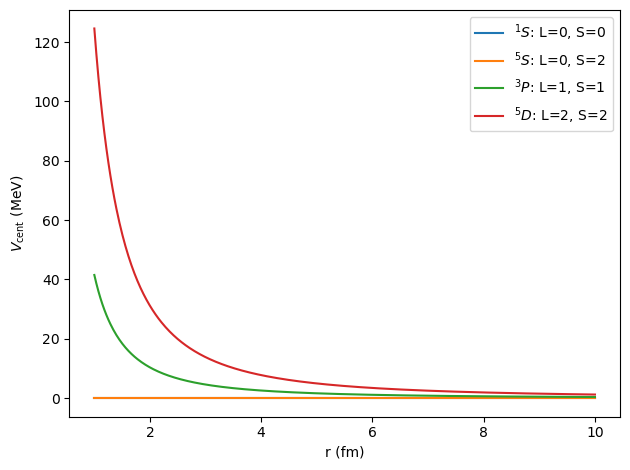

In [14]:
# Generate r values (distance in fm)
r_fm = np.linspace(1, 10, 500)

# Plot the potential for each state
plt.figure()
for state in states:
    L = state["L"]
    plt.plot(r_fm, V_cent(r_fm, L), label=state["state"])


# Customise the plot
plt.xlabel("r (fm)")
plt.ylabel("$V_{\\rm cent}$ (MeV)")
plt.legend()
plt.tight_layout()
# plt.savefig("cent-potential-D2.png", dpi=600)
plt.show()

### Total effective potential

Taken all together, we can see both the Coulomb barrier and the presence of the attractive nuclear potential on the other side of the barrier.

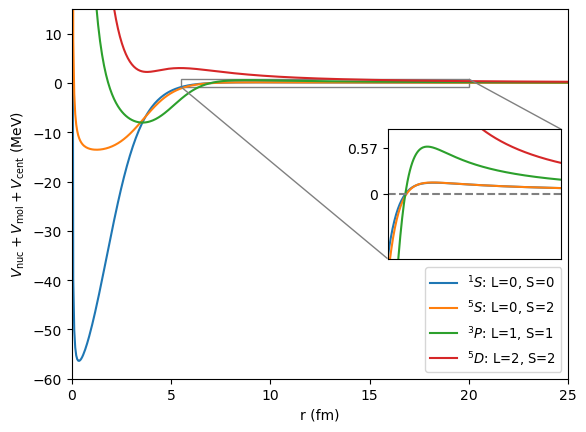

In [15]:
fig, ax = plt.subplots()

# Generate r values (distance in fm)
r_fm = np.linspace(0.01, 25, 500)

# Add inset with a zoomed-in section
ax_inset = inset_axes(ax, width="35%", height="35%", loc='center right')

# Mark the zoomed-in area on the main plot
mark_inset(ax, ax_inset, loc1=3, loc2=1, fc="none", ec="0.5")

# Calculate the total effective potential and plot it on both the main and inset axes
for state in states:
    V0, r_S, a_S, L = state["V0"], state["r_S"], state["a_S"], state["L"]
    V_eff = V_nuc(r_fm, V0, r_S, a_S) + V_cent(r_fm, L) + V_mol(r_fm)
    ax.plot(r_fm, V_eff, label=state["state"])
    ax_inset.plot(r_fm, V_eff, label=state["state"])


# Customise the main plot
ax.set_xlabel("r (fm)")
ax.set_ylabel("$V_{\\rm nuc} + V_{\\rm mol} + V_{\\rm cent}$ (MeV)")
ax.legend(loc="lower right", fontsize=9.5)
ax.set_ylim(-60,15)
ax.set_xlim(0,25)

# Customise the inset plot
x1, x2, y1, y2 = 5.5, 20, -0.8, 0.8  # specify the limits for the inset
ax_inset.axhline(0, color='gray', linestyle='dashed')
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
ax_inset.set_yticks([0,0.57])
ax_inset.set_xticks([])
ax_inset.set_yticklabels(['0','0.57'])

# plt.savefig("total-potential-D2.png", dpi=600)
plt.show()


## Calculating the Gamow factor $G$

We first need to define a radial grid that has high resolution near the nucleus and lower resolution at greater distance. We do this because the potential changes a lot when we get closer to the nucleus and so when we're doing the integration for calculating the Gamow factor then we'll incur a lot of error if we don't do this.

In [16]:
# Remember r is in fm
Nr = 30000
rmin = 0.03
rmax = 500000 # this is 500pm
r_fm = np.geomspace(rmin, rmax, Nr) # this creates a logarithmic spacing in the r points

To get a sense of the spacing between the r points, let's visualise a subset of the points.

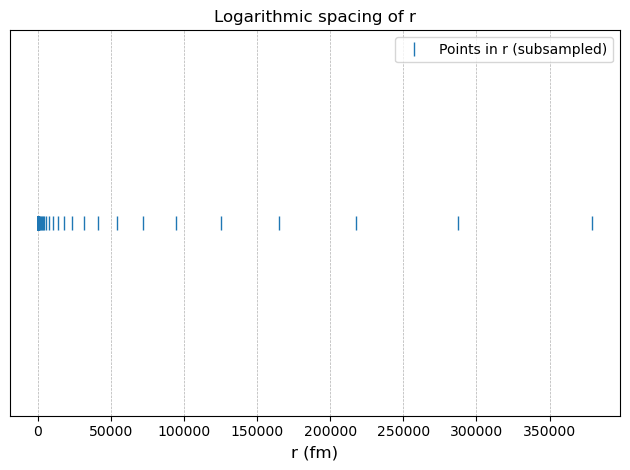

In [17]:
plt.figure()
plt.plot(r_fm[::500], np.zeros_like(r_fm[::500]), '|', markersize=10, label='Points in r (subsampled)')
plt.title("Logarithmic spacing of r")
plt.xlabel("r (fm)", fontsize=12)
plt.yticks([])  # Remove y-axis ticks for clarity
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Now, we will define a function to do the integration that's required to calculate the Gamow factor:

$$G = \int_{r_1}^{r_2} \sqrt{\frac{2\mu}{\hbar^2}\left[V_{\rm eff}(r) - E\right]} \, dr$$

Conceptually, we'll imagine that we can place the deuterons at a specific starting separation $r_{\rm start}$. This starting separation will imbue the deuterons with an energy $E$ that matches the effective potential at that separation. In other words, $E = V_{\rm eff}$, the deuterons are stationary and the they start off at one of the classical turning points $r_{\rm start} = r_{2}$. We then have to integrate down to $r_1$ by finding the other turning point $r_1$ where $E = V_{\rm eff} $.

In [18]:
def calculate_G(r, V, r_start):
    
    # Particles are separated by r_start. 
    # The energy, E, that the particles must have to be at r_start is V(r_start)
    r_start_index = np.where(r > r_start)[0][0]
    E = V[r_start_index]

    # The Gamow factor is calculated based on integrating V-E between the classical turning points.
    V_minus_E = V - E
    
    # We don't have to explicitly calculate the turning points. We can instead integrate from
    # r_start down to some small radius within the nuclear potential well, e.g. 5 fm.
    # We can do this by zeroing out the negative values of V-E in that range.

    V_minus_E = np.maximum(V_minus_E, 0) # negative values of V_minus_E are set to 0
    
    # Determine index of r = 5 fm where we'll cut-off the integration from below
    r_5fm_index = np.where(r > 5)[0][0]
    
    # Create the slice of r and V_minus_E in which we'll do the integration
    r_slice = r[r_5fm_index:r_start_index]
    V_minus_E_slice = V_minus_E[r_5fm_index:r_start_index]
    

    # Perform the integration using the trapezoidal rule
    integral = trapz(np.sqrt(V_minus_E_slice), r_slice)

    # Compute the Gamow factor, remembering to convert everything back to SI units
    # fm -> m needs factor 1e-15
    # MeV -> J needs factor np.sqrt(1e6 * eV_to_J) - Remember V-E is under a square root in the integral
    G = np.sqrt((2 * muDD) / (hbar**2)) * integral * 1e-15 * np.sqrt(1e6 * eV_to_J)

    return G

Now, we're ready to calculate the Gamow factor for the different $\rm D_2$ states. We just have to choose a starting separation for the deuterons. We'll start with the equilibrium separation in gas, i.e. 74 pm.

In [19]:
r_start = 74000
gamow_74 = []

for state in states:
    V_eff = V_nuc(r_fm, state["V0"], state["r_S"], state["a_S"]) + V_cent(r_fm, state["L"]) + V_mol(r_fm)
    G = calculate_G(r_fm, V_eff, r_start)
    exp2G = np.exp(-2*G)
    gamow_74.append({
        "state": state['state'],
        "$G$": G,
        "$e^{-2G}$": exp2G
    })

# Convert the list of dictionaries to a DataFrame
gamow_74 = pd.DataFrame(gamow_74)

# Display the DataFrame
gamow_74

,state,$G$,$e^{-2G}$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83


In order to calculate the fusion rate $\Gamma$, we now need to come back calculate the volume factor and the the nuclear relaxation/decay rate $\gamma$ in:

$$P = \frac{v_{nuc}}{v_{mol}}e^{-2 G}\gamma$$

## Volume factor for $D_2$

The ratio of the nuclear volume to molecular volume, ${v_{nuc} / v_{mol}}$, depends slightly on the state of the $\rm D_2$ molecules. To estimate the ratio, we begin by defining the equilibrium bond lengths for different electronic states of a $ \text{D}_2 $ molecule in terms of the Bohr radius ($ a_0 $):

- For the S state: $ R_{0S} = 1.401080 \times a_0 $
- For the P state: $ R_{0P} = R_{0S} + 0.001 \times 10^{-10} \, \text{m} $
- For the D state: $ R_{0D} = R_{0S} + 0.002 \times 10^{-10} \, \text{m} $

Next, we calculate the de Broglie wavelength of the relative motion ($ \Delta R $) using the formula:

$$
\Delta R = a_0 \sqrt{\frac{I_H}{\hbar \omega_{0DD}}} \sqrt{\frac{2 m_e c^2}{M_{D} c^2}}
$$

where $ I_H $ is the ionization potential of hydrogen in eV, $ \hbar \omega_{0DD} $ is the zero-point energy (0.3862729 eV), $ m_e c^2 $ is the electron mass in MeV, and $ M_D c^2 $ is the deuteron mass in MeV.

The molecular volumes ($ v_{mol} $) for the S, P, and D states are computed as follows:

- S: $ v_{mol} = 2 \pi R_{0S} \left(\pi \Delta R^2\right) $
- P: $ v_{mol} = 2 \pi R_{0P} \left(\pi \Delta R^2\right) $
- D: $ v_{mol} = 2 \pi R_{0D} \left(\pi \Delta R^2\right) $

The nuclear volume ($ v_{nuc} $) of the deuterium nucleus is calculated assuming a spherical shape with a radius of 5 fm:

$$
v_{nuc} = \frac{4}{3} \pi \left(5 \times 10^{-15} \, \text{m}\right)^3
$$

Finally, the volume ratios of the nuclear volume to the molecular volume for the S, P, and D states are calculated as:

- S: $ \frac{v_{nuc}}{v_{mol}} = 6.66 \times 10^{-12} $
- P: $ \frac{v_{nuc}}{v_{mol}} = 6.65 \times 10^{-12} $
- D: $ \frac{v_{nuc}}{v_{mol}} = 6.64 \times 10^{-12} $

In [20]:
for i, ratio in enumerate([6.66e-12, 6.66e-12, 6.65e-12, 6.64e-12]):
    states[i]["$v_{nuc}/v_{mol}$"] = ratio
    gamow_74.loc[i,"$v_{nuc}/v_{mol}$"] = ratio

gamow_74

,state,$G$,$e^{-2G}$,$v_{nuc}/v_{mol}$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77,6.660000e-12
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77,6.660000e-12
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79,6.650000e-12
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83,6.640000e-12


## Nuclear relaxation/decay for $\rm D_2$ fusion

When the deuterons tunnel through the Coulomb barrier, for a very brief moment, they form a state that can be recognised as an excited state of $\rm ^4He$ (often denoted $\rm ^4He^*$). There are several excited states and they decay via different "channels". For example:
- Relaxation into the ground state $\rm ^4He$ with the emission of a gamma ray
- Decay into a proton and triton
- Decay into a neutron and $\rm ^3He$

Different $\rm D_2$ states tunnel to different $\rm ^4He^*$ states which have unique decay rates $\gamma$. The rates can be found in Table 3.0.1 (page 19) of [Tilley et.al](https://www.sciencedirect.com/science/article/abs/pii/037594749290635W).

**For the $^5S$ state of $\rm D_2$**:

We must refer to the $\rm ^5S$ $J^\pi=2^+$ state of $\rm ^4He^*$ at 27.42 MeV, whose line width is:

$$
\hbar \gamma_{^5S} ~=~ 0.25 + 0.23~\text{MeV} ~=~ 0.48~ \text{MeV}
$$


and whose associated decay rate and lifetime is:

$$
\gamma_{^5S} ~=~ {0.48 ~ {\rm MeV} \over \hbar} ~=~ 7.3 \times 10^{20}~{\rm s}^{-1}
$$
$$
\tau_{^5S} ~=~ {\hbar \over 0.48 ~ {\rm MeV} } ~=~ 1.4 \times 10^{-21} ~{\rm sec} 
$$

We don't have data for the $^1S$ state, so we'll use the $^5S$ result.

**For the $^3P$ state of $\rm D_2$**:

We must refer to the $\rm ^3P$ $J^\pi=1^-$ state of $\rm ^4He^*$ at 28.37 MeV, whose line width is:

$$
\hbar \gamma_{^3P} ~=~ 0.07 + 0.08~\text{MeV} ~=~ 0.15~ \text{MeV}
$$


and whose associated decay rate and lifetime is:

$$
\gamma_{^3P} ~=~ {0.15 ~ {\rm MeV} \over \hbar} ~=~ 2.3 \times 10^{20}~{\rm s}^{-1}
$$
$$
\tau_{^3P} ~=~ {\hbar \over 0.15 ~ {\rm MeV} } ~=~ 4.4 \times 10^{-21} ~{\rm sec} 
$$

**For the $^5D$ state of $\rm D_2$**:

We must refer to the $\rm ^5D$ $J^\pi=2^+$ state of $\rm ^4He^*$ at 29.89 MeV, whose line width is:

$$
\hbar \gamma_{^5D} ~=~ 0.04 + 0.04~\text{MeV} ~=~ 0.08~ \text{MeV}
$$


and whose associated decay rate and lifetime is:

$$
\gamma_{^5D} ~=~ {0.08 ~ {\rm MeV} \over \hbar} ~=~ 1.2 \times 10^{20}~{\rm s}^{-1}
$$
$$
\tau_{^5D} ~=~ {\hbar \over 0.08 ~ {\rm MeV} } ~=~ 8.2 \times 10^{-21} ~{\rm sec} 
$$


In [21]:
for i, gamma in enumerate([7.3e20, 7.3e20, 2.3e20, 1.2e20]):
    states[i]["gamma"] = gamma
    gamow_74.loc[i,"$\gamma$"] = gamma

gamow_74

,state,$G$,$e^{-2G}$,$v_{nuc}/v_{mol}$,$\gamma$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77,6.660000e-12,7.300000e+20
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77,6.660000e-12,7.300000e+20
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79,6.650000e-12,2.300000e+20
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83,6.640000e-12,1.200000e+20


## Calculating the fusion rates for 74 pm separation

Now we have everything we need to calculate the fusion rates via

$$\Gamma = \frac{v_{nuc}}{v_{mol}}e^{-2G}\gamma$$

In [22]:
gamow_74["$\Gamma$"] = gamow_74["$v_{nuc}/v_{mol}$"]*gamow_74["$e^{-2G}$"]*gamow_74["$\gamma$"]
gamow_74

,state,$G$,$e^{-2G}$,$v_{nuc}/v_{mol}$,$\gamma$,$\Gamma$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77,6.660000e-12,7.300000e+20,1.585096e-67
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77,6.660000e-12,7.300000e+20,1.595625e-67
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79,6.650000e-12,2.300000e+20,4.946656e-70
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83,6.640000e-12,1.200000e+20,3.383785e-74


It's instructive to compare the Gamow based fusion rates to those calculated by solving the Schrödinger equation fully. One of the earliest calculations was done by [Koonin and Nauenberg in 1989](https://www.nature.com/articles/339690a0). They calculated a fusion rate for an $S$ state using the molecular potential and neglecting the nuclear potential. 

Their rate was calculated to be $\Gamma = 3 \times 10^{-64} \, \rm s^{-1}$

Although the Gamow rate is 3 orders of magnitude below the more accurate value, the Gamow approach allows us to incorporate screening effects more easily, so this approach has its own set of benefits. We'll see this later in the notebook.

## Fusion rates as a function of deuteron separation

In $\rm D_2$ gas, the deuteron separation is about 74 pm. When deuterium interacts with metals like palladium, the separation can be very different. For example, deuterons in the "O-sites" of a palladium lattice are separated by about 250 pm, whereas the H-H separation in "di-hydrogen" bound to palladium is 85 pm . It's therefore of interest to calculate the fusion rate as a function of deuteron separation.

In general, it's not possible to vary just the deuteron separation because one must also self-consistently solve for the electron screening effects that permits the desired deuteron separation.

As a first approximation, we can calculate the fusion rate using the bare Coulomb potential instead of the molecular one and then normalise it to the Koonin and Nauenberg rate at 74 pm. That will give us an order of magnitude sense for how we might expect the fusion rate to change as the deuteron separation changes when we don't account for screening. This involves repeating what we did above but for different values of $r_2$ in the Gamow factor calculation:

$$G = \int_{r_1}^{r_2} \sqrt{\frac{2\mu}{\hbar^2}\left[V_{\rm eff}(r) - E\right]} \, dr$$

keeping in mind that we'll now be using $V_{\rm coulomb}$ instead of $V_{\rm mol}$.

We'll consider the $^5S$ state for this demonstration.

In [23]:
state_5S = states[1]
state_5S

{'state': '$^5S$: L=0, S=2',
 'L': 0,
 'S': 2,
 'V0': -15.5,
 'r_S': 3.59,
 'a_S': 0.81,
 '$v_{nuc}/v_{mol}$': 6.66e-12,
 'gamma': 7.3e+20}

In [24]:
r2s = np.arange(50000, 300000, 1000)
gamow_many_r = []

for r_start in r2s:
    V_eff = V_nuc(r_fm, state_5S["V0"], state_5S["r_S"], state_5S["a_S"]) + V_cent(r_fm, state_5S["L"]) + V_coulomb(r_fm)
    G = calculate_G(r_fm, V_eff, r_start)
    exp2G = np.exp(-2*G)
    Gamma = state_5S["$v_{nuc}/v_{mol}$"] * exp2G * state_5S["gamma"]
    gamow_many_r.append({
        "$r_2$": r_start,
        "$G$": G,
        "$e^{-2G}$": exp2G,
        "$\Gamma$": Gamma
    })

# Convert the list of dictionaries to a DataFrame
gamow_many_r = pd.DataFrame(gamow_many_r)

# Display the first few rows of the DataFrame
gamow_many_r.head()

,$r_2$,$G$,$e^{-2G}$,$\Gamma$
0,50000,91.073073,7.851162e-80,3.817078e-70
1,51000,91.975013,1.292762e-80,6.285152e-71
2,52000,92.885745,2.091544e-81,1.016867e-71
3,53000,93.805355,3.324331e-82,1.616223e-72
4,54000,94.680624,5.773710e-83,2.807062e-73


Now, normalising to the Koonin value

In [25]:
Koonin_norm = 3e-64/gamow_many_r[gamow_many_r["$r_2$"]==74000]["$\Gamma$"].values[0]
gamow_many_r["$\Gamma$ (normalised)"] = gamow_many_r["$\Gamma$"]*Koonin_norm

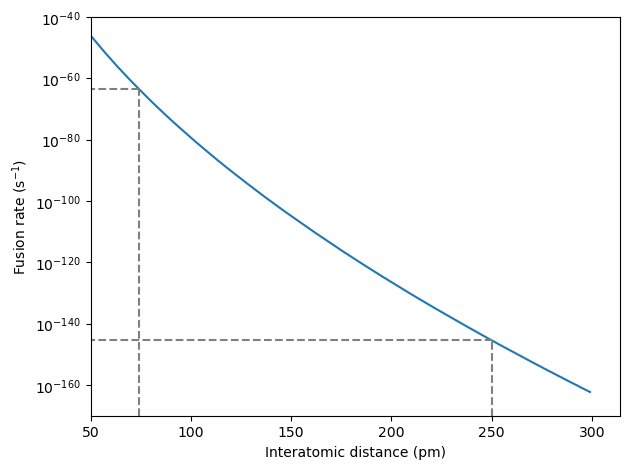

In [26]:
plt.plot(gamow_many_r["$r_2$"]/1e3, gamow_many_r["$\Gamma$ (normalised)"])

# Closest values to 74000 and 250000
target_values = [74000, 250000]
closest_points = gamow_many_r.iloc[[abs(gamow_many_r["$r_2$"] - target).idxmin() for target in target_values]]

# Adding vertical and horizontal lines for the closest points
for _, row in closest_points.iterrows():
    r_value = row["$r_2$"]
    gamma_value = row["$\Gamma$ (normalised)"]
    # Vertical line from bottom to the curve
    plt.plot([r_value / 1e3, r_value / 1e3], [1e-170, gamma_value], color='gray', linestyle='--')
    # Horizontal line from the vertical line to the y-axis
    plt.plot([0, r_value / 1e3], [gamma_value, gamma_value], color='gray', linestyle='--')

plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.yticks([1e-40,1e-60,1e-80, 1e-100, 1e-120, 1e-140, 1e-160])

plt.xlabel('Interatomic distance (pm)')
plt.ylabel('Fusion rate (s$^{-\mathregular{1}}$)')

plt.xlim(left=gamow_many_r["$r_2$"].min()/1e3)

plt.ylim(ymin=1e-170)

plt.tight_layout()

plt.show()
# plt.savefig("fusion-rate-distance.png", dpi=600)

# # COMMENTED OUT CODE CAN BE USED TO REPRODUCE THE FORMAT OF PLOTS FROM https://doi.org/10.1088/1367-2630/ad091c
# fig, ax = plt.subplots(figsize=(8, 6))
# plt.yticks([1e-40,1e-60,1e-80, 1e-100, 1e-120, 1e-140, 1e-160], [f"{tick:.0E}" for tick in y_ticks])
# plt.xlabel('Interatomic distance (pm)', fontsize=25, fontname='Arial')
# plt.ylabel('Fusion rate (s$^{-\mathregular{1}}$)', fontsize=25, fontname='Arial')
# plt.xticks(fontsize=25, fontname='Arial')
# plt.yticks(fontsize=25, fontname='Arial')
# plt.gca().invert_xaxis()
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

From the above plot, we can see that, in the absence of electron screening, the fusion rate for deuterium in palladium O-sites (at 250 pm) would be about 82 orders of magnitude smaller than for $\rm D_2$ in a gas.

Let's now see how much of an effect electron screening can have.

## Screened fusion rates

We know that $\rm D_2$ can get absorbed into metals like palladium. The abundance of electrons inside a metal invites us to consider more deeply the effect of electron screening on fusion rates. 

Simplistically, electron screening reduces the positive electrostatic repulsion between nuclei and results in a reduced interatomic distance and hence higher fusion rates. Most theoretical descriptions of screening in metals have been developed to attempt to explain anomalously high fusion rates in low energy beam-target experiments (see e.g. [Huke et.al](http://dx.doi.org/10.1103/PhysRevC.78.015803)). These models have had some success, but there are still discrepancies with experiments and a rigorous theory of the extremely low energy regime has yet to be agreed upon.

We will construct a screening model that incorporates aspects of the molecular potential we've used for $\rm D_2$ in addition to the standard screening ideas from the beam-target scenario.

The simplest model of screening for the beam-target scenario takes the form of a screened Coulomb potential:

$$V_{\rm screened} = \frac{e^2}{4\pi\epsilon_0r} e^{-\frac{r}{\lambda}}$$

$\lambda$ is known as the screening length and gives a measure of the size of an electron cloud surrounding a nucleus. The screening length can be expressed as terms of a screening energy, $U_e$, via:

$$U_e = \frac{e^2}{4\pi\varepsilon_0 \lambda}$$

which has an upper limit in metals of about 300 eV.

While it is common to simplify $V_{\rm screened}$ by performing a Taylor expansion of the exponential, this is only justified for high beam energies $E \gg U_e$ where the classical tuning points for tunelling satisfy $r \ll \lambda$. For very low energies, the full exponential must be used.

To incorporate these screening ideas in a way that reduces to the Kolos molecular potential for small screening energies, we can simply take an exponentially screened form of our molecular potential:

$$V_{\rm screened} = V_{\rm mol} e^{-\frac{r}{\lambda}} $$
 
$$V_{\rm screened}= \frac{2}{r}(1 - b_1r - b_2r^2) e^{-\alpha r^s}e^{-\frac{r}{\lambda}}$$


In [27]:
def V_screened_mol(r_fm, Ue):
    if Ue == 0:
        return V_mol(r_fm)
    else:
        Ue_J = Ue * eV_to_J
        screeninglength_m = (e**2 / (4 * np.pi * eps0)) / Ue_J
        screeninglength_fm = screeninglength_m * 1e15 # in fm
    
    return V_mol(r_fm)*np.exp(-r_fm / screeninglength_fm)

We can see in the figure below, that effect of the increasing screening is to transition from a well defined $D_2$ molecular potential to a screened Coulomb potential. It should be noted this model is more of a mathematical convenience than a physical model because of the aforementioned lack of consensus in screening models.

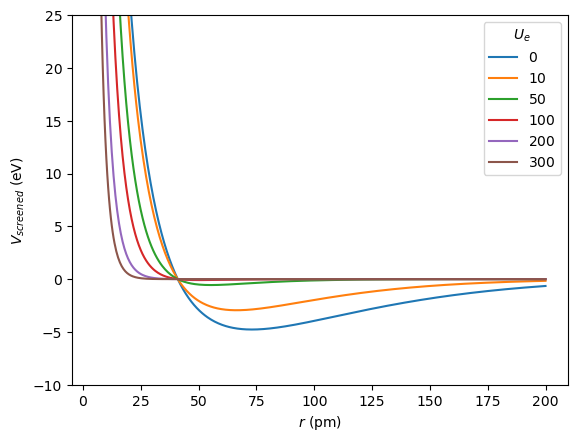

In [28]:
# Range for r in pm for plotting and fm for the potential functions
pm = np.linspace(5, 200, 500)
fm = pm*1000
# Plot
plt.figure()
for Ue in [0, 10, 50, 100, 200, 300]:
    plt.plot(pm, V_screened_mol(fm,Ue)*1e6, label=f"${Ue}$")

plt.xlabel(r"$r$ (pm)")
plt.ylabel(r"$V_{screened}$ (eV)")
plt.legend(title=r"$U_e$")
plt.ylim(top=25, bottom=-10)
# plt.savefig("screened-mol-potential-D2.png", dpi=600)
plt.show()

We now once again repeat the Gamow factor calculation:

$$G = \int_{r_1}^{r_2} \sqrt{\frac{2\mu}{\hbar^2}\left[V_{\rm eff}(r) - E\right]} \, dr$$

but now using $V_{\rm screened}$ instead of $V_{\rm mol}$ for the calculation of $V_{\rm eff}$.

We'll keep $r_2 = 74 \, \rm pm$ fixed, but keep in mind that, because the potential gets increasingly flattened as we increase $U_e$, the deuteron separation effectively moves inwards.

Let's also again consider the $^5S$ state for this demonstration.

We're going to normalise the results so that $U_e = 0$ corresponds to the Koonin and Nauenberg rate. This is an attempt to combine the best of both worlds by benefiting from the accuracy of Koonin's solution for the unscreened fusion rate and also benefiting from our simple way of including screening.


In [29]:
Ues = np.linspace(0, 200, 100)
gamow_many_Ue = []

for Ue in Ues:
    V_eff = V_nuc(r_fm, state_5S["V0"], state_5S["r_S"], state_5S["a_S"]) + V_cent(r_fm, state_5S["L"]) + V_screened_mol(r_fm, Ue)
    G = calculate_G(r_fm, V_eff, 74000)
    exp2G = np.exp(-2*G)
    Gamma = state_5S["$v_{nuc}/v_{mol}$"] * exp2G * state_5S["gamma"]
    gamow_many_Ue.append({
        "$U_e$": Ue,
        "$G$": G,
        "$e^{-2G}$": exp2G,
        "$\Gamma$": Gamma
    })

# Convert the list of dictionaries to a DataFrame
gamow_many_Ue = pd.DataFrame(gamow_many_Ue)

# Display the first few rows of the DataFrame
gamow_many_Ue.head()

,$U_e$,$G$,$e^{-2G}$,$\Gamma$
0,0.000000,88.055305,3.281962e-77,1.595625e-67
1,2.020202,86.461805,7.947499e-76,3.863915e-66
2,4.040404,84.961599,1.596954e-74,7.764070e-65
3,6.060606,83.558902,2.640340e-73,1.283680e-63
4,8.080808,82.249834,3.619941e-72,1.759943e-62


Now, normalising to the Koonin value

In [30]:
Koonin_norm = 3e-64/gamow_many_Ue[gamow_many_Ue["$U_e$"]==0]["$\Gamma$"].values[0]
gamow_many_Ue["$\Gamma$ (normalised)"] = gamow_many_Ue["$\Gamma$"]*Koonin_norm

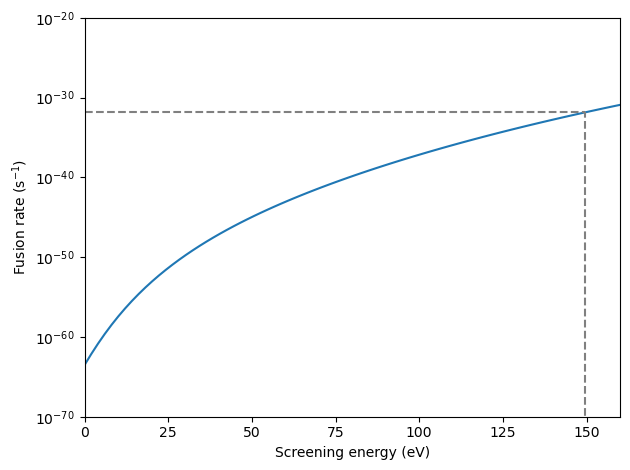

In [31]:
plt.plot(gamow_many_Ue["$U_e$"], gamow_many_Ue["$\Gamma$ (normalised)"])

# Closest values to 150
target_values = [150]
closest_points = gamow_many_Ue.iloc[[abs(gamow_many_Ue["$U_e$"] - target).idxmin() for target in target_values]]

# Adding vertical and horizontal lines for the closest points
for _, row in closest_points.iterrows():
    U_value = row["$U_e$"]
    gamma_value = row["$\Gamma$ (normalised)"]
    # Vertical line from bottom to the curve
    plt.plot([U_value, U_value], [1e-170, gamma_value], color='gray', linestyle='--')
    # Horizontal line from the vertical line to the y-axis
    plt.plot([0, U_value], [gamma_value, gamma_value], color='gray', linestyle='--')

plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.yticks([1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80])

plt.xticks([0, 25, 50, 75, 100, 125, 150])

plt.xlabel('Screening energy (eV)')
plt.ylabel('Fusion rate (s$^{-\mathregular{1}}$)')

plt.xlim([0, 160])
plt.ylim(ymin=1e-70)

plt.tight_layout()
# plt.savefig("fusion-rate-screening.png", dpi=600)
plt.show()

# # COMMENTED OUT CODE CAN BE USED TO REPRODUCE THE FORMAT OF PLOTS FROM https://doi.org/10.1088/1367-2630/ad091c
# fig, ax = plt.subplots(figsize=(8, 6))
# plt.yticks([1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80], [f"{tick:.0E}" for tick in y_ticks])
# plt.xlabel('Screening energy (eV)', fontsize=25, fontname='Arial')
# plt.ylabel('Fusion rate (s$^{-\mathregular{1}}$)', fontsize=25, fontname='Arial')
# plt.xticks(fontsize=25, fontname='Arial')
# plt.yticks(fontsize=25, fontname='Arial')
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

For a metal like palladium, $U_e$ has been estimated as $U_e \approx 150 \, \rm eV$ ([Huke et al. 2008](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.78.015803) ). This suggests that fusion rates for deuterium inside palladium could be about 30 orders of magnitude larger than for $D_2$ in a gas.  In actuality, screening may be higher, especially when considering special sites in the metal such as defects (see [Kowalska et al. 2023](https://www.mdpi.com/1996-1944/16/18/6255) ).

## Next up

In the next fusion rates notebook, calculate fusion rates using a more accurate method, namely by solving the Schrödinger equation.